In [1]:
import os
from functools import partial
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import sklearn.datasets

import xgboost as xgb
from xgboost import XGBRegressor

from lightgbm import log_evaluation
import lightgbm as lgb

import catboost
from catboost import CatBoostRegressor, MultiTargetCustomMetric

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold  # KFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

print(lgb.__version__)
print(xgb.__version__)
print(catboost.__version__)

4.2.0
2.0.3
1.2.7


In [2]:
INPUT_DIR = Path("/kaggle/input/child-mind-institute-problematic-internet-use")
SERIES_TRAIN_DIR = INPUT_DIR / "series_train.parquet"
SERIES_TEST_DIR = INPUT_DIR / "series_test.parquet"

OUTPUT_DIR = Path("./")

In [3]:
DRYRUN = False

In [4]:
train_df = pd.read_csv(INPUT_DIR / "train.csv")
test_df = pd.read_csv(INPUT_DIR / "test.csv")

In [5]:
season = [c for c in train_df.columns if "Season" in c]
season

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'PCIAT-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [6]:
train_df = train_df.drop(season, axis=1)

In [7]:
season.remove("PCIAT-Season")
season

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [8]:
test_df = test_df.drop(season, axis=1)

In [9]:
labels = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

<Axes: >

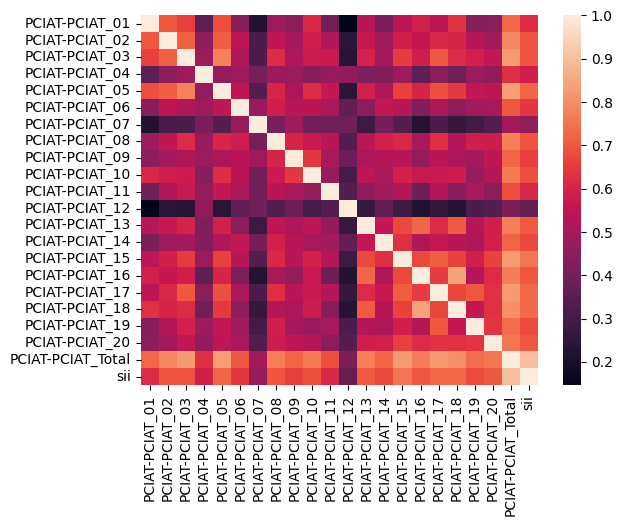

In [10]:
import seaborn as sns

sns.heatmap(train_df[labels].corr())

In [11]:
train_df[labels].corr()["sii"].sort_values()

PCIAT-PCIAT_12       0.370844
PCIAT-PCIAT_07       0.460864
PCIAT-PCIAT_04       0.589342
PCIAT-PCIAT_11       0.609964
PCIAT-PCIAT_01       0.617883
PCIAT-PCIAT_06       0.645596
PCIAT-PCIAT_09       0.660485
PCIAT-PCIAT_14       0.675953
PCIAT-PCIAT_19       0.683293
PCIAT-PCIAT_10       0.689972
PCIAT-PCIAT_02       0.694597
PCIAT-PCIAT_03       0.694736
PCIAT-PCIAT_08       0.695458
PCIAT-PCIAT_16       0.698566
PCIAT-PCIAT_20       0.703013
PCIAT-PCIAT_13       0.705679
PCIAT-PCIAT_05       0.722722
PCIAT-PCIAT_17       0.729867
PCIAT-PCIAT_18       0.731112
PCIAT-PCIAT_15       0.751399
PCIAT-PCIAT_Total    0.899681
sii                  1.000000
Name: sii, dtype: float64

In [12]:
high_sii = train_df[labels].corr()["sii"]
high_sii[high_sii.sort_values()>0.7].index

Index(['PCIAT-PCIAT_05', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_17',
       'PCIAT-PCIAT_18', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii'],
      dtype='object')

In [13]:
high_corr_labels = ['PCIAT-PCIAT_05', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_17',
       'PCIAT-PCIAT_18', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']

In [14]:
categorical_columns = ['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
'PreInt_EduHx-computerinternet_hoursday']

In [15]:
class SingleTargetCustomMetric:
    def __init__(self, name='custom_metric'):
        self.name = name
    
    def get_final_error(self, error, weight):
        # メトリクスの最終的な計算方法を定義
        return np.mean(error)
    
    def is_max_optimal(self):
        # メトリクスが最大化したいものかどうか
        return False  # 通常、エラーメトリクスは小さいほど良い
    
    def evaluate(self, approxes, target, weight):
        # カスタムメトリクスの計算ロジック
        # approxes: モデルの予測値
        # target: 実際のターゲット値
        # weight: サンプルの重み
        
        # 例: 独自の評価関数（この例では単純な平均絶対誤差）
        errors = np.abs(approxes - target)
        return errors, 1  # エラー配列と重み

In [16]:
def quadratic_weighted_kappa(preds, data):
    y_true = data.get_label()
    y_pred = preds.clip(y_min, y_max).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk, True


def qwk_obj(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.clip(y_min, y_max)
    f = 1 / 2 * np.sum((preds - labels) ** 2)
    g = 1 / 2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g**2) * len(labels)
    hess = np.ones(len(labels))
    return grad, hess

def MakeObj(y_true, y_pred):
    "This function is the common custom objective for LGBM and XGB"
    
    labels = y_true + a
    preds  = y_pred + a
    preds  = preds.clip(0, np.inf)
    f      = 1/2*np.sum((preds-labels)**2)
    g      = 1/2*np.sum((preds-a)**2+b)
    df     = preds - labels
    dg     = preds - a
    grad   = (df/g - f*dg/g**2)*len(labels)
    hess   = np.ones(len(labels))
    
    return grad, hess

def quadratic_weighted_kappa_xgb(preds, data):
    y_true = data.get_label()
    y_pred = preds.clip(y_min, y_max).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk


def extended_cohen_kappa_score(labels, preds):
    f = np.sum((preds - labels) ** 2)
    g = np.sum((preds - a) ** 2 + b)
    return 1 - f / g

In [17]:
class config:
    catboost_param = dict(
    loss_function="MultiRMSE",
    #eval_metric=MultiTargetQWK(),
    iterations=1 if DRYRUN else 100000,
    learning_rate=0.1,
    depth=8,
    early_stopping_rounds=100,
    random_seed=3
    )
    
    lightgbm_param = dict(
        objective=qwk_obj,
        metric="None",
        verbosity = -1,
        learning_rate = 0.01,
        num_leaves = 128,
        max_depth = 7,
        lambda_l1 = 0.31201869964930007,
        lambda_l2 = 0.27854462725379414,
        feature_fraction=0.5390178464396012,
        bagging_fraction=0.7988830539024434,
        random_seed=3,
    )

    xgboost_param = dict(
        objective=None,
        device="cpu",
        learning_rate=0.03, 
        n_estimators =100,
        max_depth    =4, 
        colsample_bytree= 0.55, 
        colsample_bynode= 0.60,
        colsample_bylevel= 0.70,                     
        reg_alpha    =2.50, 
        reg_lambda   =7.50,
        verbose      =0,
        random_state=1,
        enable_categorical=True,
        seed=3,
        #callbacks    =[XGBLogging(epoch_log_interval= 0)],
    )

In [18]:
def naive_mean_ensemble(models, features):
    predictions = []
    for model in tqdm(models):
        predictions.append(model.predict(features))
    return np.mean(predictions, axis=0)

In [19]:
from numpy.typing import ArrayLike, NDArray
from functools import partial

class OptimizedRounder:
    """
    A class for optimizing the rounding of continuous predictions into discrete class labels using Optuna.
    The optimization process maximizes the Quadratic Weighted Kappa score by learning thresholds that separate
    continuous predictions into class intervals.

    Args:
        n_classes (int): The number of discrete class labels.
        n_trials (int, optional): The number of trials for the Optuna optimization. Defaults to 100.

    Attributes:
        n_classes (int): The number of discrete class labels.
        labels (NDArray[np.int_]): An array of class labels from 0 to `n_classes - 1`.
        n_trials (int): The number of optimization trials.
        metric (Callable): The Quadratic Weighted Kappa score metric used for optimization.
        thresholds (List[float]): The optimized thresholds learned after calling `fit()`.

    Methods:
        fit(y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
            Fits the rounding thresholds based on continuous predictions and ground truth labels.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions that need to be rounded.
                y_true (NDArray[np.int_]): Ground truth class labels.

            Returns:
                None

        predict(y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
            Predicts discrete class labels by rounding continuous predictions using the fitted thresholds.
            `fit()` must be called before `predict()`.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions to be rounded.

            Returns:
                NDArray[np.int_]: Predicted class labels.

        _normalize(y: NDArray[np.float_]) -> NDArray[np.float_]:
            Normalizes the continuous values to the range [0, `n_classes - 1`].

            Args:
                y (NDArray[np.float_]): Continuous values to be normalized.

            Returns:
                NDArray[np.float_]: Normalized values.

    References:
        - This implementation uses Optuna for threshold optimization.
        - Quadratic Weighted Kappa is used as the evaluation metric.
    """

    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = max(thresholds) if i > 0 else min(self.labels)
                high = max(self.labels)
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")
        study.optimize(
            objective,
            n_trials=self.n_trials,
        )
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        # normalize y_pred to [0, n_classes - 1]
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

In [20]:
def model_lightgbm(X, y, test_x, folds):
    init_score = 0
    #skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    #folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(X, y)]
    
    params = config.lightgbm_param
    
    models = lgb.cv(
        params=params,
        train_set=lgb.Dataset(X, y, init_score=[init_score]*len(X)),
        num_boost_round=1000,
        folds=folds,
        feval=quadratic_weighted_kappa,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100)
        ],
        return_cvbooster=True
    )["cvbooster"].boosters

    preds_train = np.zeros(len(X))
    for model, (idx_train, idx_valid) in zip(models, folds):
        preds_train[idx_valid] = model.predict(X.iloc[idx_valid]) + init_score
        
    # 閾値最適化
    optimizer = OptimizedRounder(n_classes=4, n_trials=300)
    optimizer.fit(preds_train, y)
    y_pred_rounded = optimizer.predict(preds_train)

    # スコアを測る
    score = cohen_kappa_score(y, y_pred_rounded, weights="quadratic")
    print("QWK:", score)

    # テストデータに対する予測値の平均をとる
    preds_test = naive_mean_ensemble(models, test_x)
    preds_test = optimizer.predict(preds_test)

    return preds_train, preds_test, models, optimizer, score

In [21]:
class SingleTargetCustomMetric:
    def __init__(self, name='custom_metric'):
        self.name = name
    
    def get_final_error(self, error, weight):
        return np.mean(error)
    
    def is_max_optimal(self):
        return True  # QWKは大きいほど良い
    
    def evaluate(self, approxes, target, weight):
        # approxesが1次元配列であることを確認
        #approx = np.clip(approxes, 0, 3).round().astype(int)
        approx = approxes[0].clip(0, 3).round().astype(int) # approxesはtupleで帰ってくる
        
        # targetが1次元配列であることを確認
        if target.ndim > 1:
            target = target.ravel()
        
        # サンプル数の整合性を確認
        if len(approx) != len(target):
            raise ValueError(f"Inconsistent sample sizes: approx {len(approx)}, target {len(target)}")
        
        # カスタムのQWK計算
        qwk = cohen_kappa_score(target, approx, weights="quadratic")
        
        return qwk, 1  # エラー値と重み
        
class MultiTargetQWK(MultiTargetCustomMetric):
    def get_final_error(self, error, weight):
        return np.sum(error)  # / np.sum(weight)

    def is_max_optimal(self):
        # if True, the bigger the better
        return True

    def evaluate(self, approxes, targets, weight):
        # approxes: 予測値 (shape: [ターゲット数, サンプル数])
        # targets: 実際の値 (shape: [ターゲット数, サンプル数])
        # weight: サンプルごとの重み (Noneも可)

        qwk_scores = []
        #print(targets)
        #print(len(targets))
        for i in range(len(targets)):
            # 各ターゲットに対してQWKを計算
            approx = np.clip(approxes[i], 0, 3).round().astype(int)
            target = targets[i]
            
            qwk = cohen_kappa_score(target, approx, weights="quadratic")
            qwk_scores.append(qwk)
        
        # 全ターゲットのQWKの平均
        return np.mean(qwk_scores), 1

    def get_custom_metric_name(self):
        return "MultiTargetQWK"
        
def model_multirmse_catboost(X, y, test_x, folds, main_target, params):
    
    models: list[CatBoostRegressor] = []
    preds_train = np.zeros(len(X))
    for i, (train_idx, val_idx) in enumerate(folds):
        train_x, valid_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, valid_y = y.iloc[train_idx], y.iloc[val_idx]
    
        # train model
        model = CatBoostRegressor(**params)
        model.fit(
            train_x,
            train_y,
            eval_set=(valid_x, valid_y),
            #cat_features=[],
            cat_features=categorical_columns,
            verbose=False,
        )
        models.append(model)
    
        # predict
        #0:len(y_sii), TARGET_COLS.index("PCIAT-PCIAT_Total")
        #preds_train[val_idx] = model.predict(valid_x)[:,list(y.columns).index(main_target)]
        preds_train[val_idx] = model.predict(valid_x)
    
    # 閾値最適化
    optimizer = OptimizedRounder(n_classes=4, n_trials=300)
    optimizer.fit(preds_train, y)
    #optimizer.fit(preds_train, y[main_target])
    y_pred_rounded = optimizer.predict(preds_train)

    # スコアを測る
    score = cohen_kappa_score(y, y_pred_rounded, weights="quadratic")
    #score = cohen_kappa_score(y[main_target], y_pred_rounded, weights="quadratic")
    print("QWK:", score)

    # テストデータに対する予測値の平均をとる
    preds_test = naive_mean_ensemble(models, test_x)
    preds_test = optimizer.predict(preds_test)

    return preds_train, preds_test, models, optimizer, score

In [22]:
class Model_xgb:

    def __init__(self):
        self.model = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        params = config.xgboost_param
        # params = {'objective': 'binary:logistic', 
        #           'silent': 1, 
        #           'random_state': 71,
        #           'eval_metric': 'logloss'}
        #num_round = 10
        params = config.xgboost_param

        train_set = xgb.DMatrix(tr_x,label=tr_y,feature_names=list(tr_x.columns), enable_categorical=True)
        valid_set = xgb.DMatrix(va_x,label=va_y,feature_names=list(va_x.columns), enable_categorical=True)

        self.model = xgb.train(params, 
                               train_set, 
                               num_boost_round=500,
                               obj=qwk_obj,
                               custom_metric=quadratic_weighted_kappa_xgb, 
                               maximize=True)
        
        #self.model = XGBRegressor(**params)
        #self.model.fit(tr_x,tr_y, eval_set=[(va_x,va_y)], verbose=100)
    def predict(self, x):
        pred = self.model.predict(xgb.DMatrix(x, enable_categorical=True))
        return pred

In [23]:
def predict_cv(model, train_x, train_y, test_x, folds):
    preds = []
    preds_test = []
    va_idxes = []

    #kf = KFold(n_splits=4, shuffle=True, random_state=71)
    models = []

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in tqdm(enumerate(folds)):
    #for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

        models.append(model)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    preds_train = preds[order]

    # 閾値最適化
    optimizer = OptimizedRounder(n_classes=4, n_trials=300)
    optimizer.fit(preds_train, train_y)
    y_pred_rounded = optimizer.predict(preds_train)

    # スコアを測る
    score = cohen_kappa_score(y, y_pred_rounded, weights="quadratic")
    print("QWK:", score)
    
    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)
    preds_test = optimizer.predict(preds_test)

    return preds_train, preds_test, models, optimizer, score

In [24]:
#予測結果を格納する
predictions = {}

In [25]:
train_not_null = train_df[train_df["sii"].isnull() == False].reset_index(drop=True)
#train_not_null = train_df.dropna(subset=high_corr_labels).reset_index(drop=True)
X = train_not_null.drop(["id"] + labels, axis=1)
y = train_not_null["sii"]

train_ids = train_not_null["id"]
test_ids = test_df["id"]

In [26]:
train_ids

0       00008ff9
1       000fd460
2       00105258
3       00115b9f
4       001f3379
          ...   
2731    ff6c2bb8
2732    ff759544
2733    ff8a2de4
2734    ffcd4dbd
2735    ffed1dd5
Name: id, Length: 2736, dtype: object

In [27]:
train_ids.shape, test_ids.shape

((2736,), (20,))

In [28]:
a = y.mean()
b = y.var(ddof=0)

y_min = y.min()
y_max = y.max()

In [29]:
#test data
test_X = test_df[X.columns]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(X, y)]

In [30]:
X[categorical_columns] = X[categorical_columns].astype("category")
test_X[categorical_columns] = test_X[categorical_columns].astype("category")

preds_oof_1, preds_test_1, models_1, optimizer_1, score_1 = model_lightgbm(X, y, test_X, folds)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 5/5 [00:00<00:00, 122.44it/s]


In [31]:
model_xgb = Model_xgb()

In [32]:
preds_oof_2, preds_test_2, models_2, optimizer_2, score_2 = predict_cv(model_xgb, X, y, test_X, folds)

5it [00:06,  1.39s/it]


QWK: 0.44154110432715665


In [33]:
preds_oof_2

array([ 0.22239438, -0.1622364 ,  0.8045562 , ...,  1.2029895 ,
        0.59411836,  1.2112141 ], dtype=float32)

In [34]:
# predictions["lightgbm_1st"] = {"id":train_ids, "pred":preds_oof_1}
# predictions["xgboost_1st"] = {"id":train_ids, "pred":preds_oof_2}

In [35]:
catboost_params = dict(
        #loss_function="MultiRMSE",
        loss_function="RMSE",
        #eval_metric=MultiTargetQWK(),
        eval_metric=SingleTargetCustomMetric(),
        iterations=1 if DRYRUN else 100000,
        learning_rate=0.01,
        depth=4,
        early_stopping_rounds=100,
    )

main_target = "sii"
train_not_null = train_df[train_df["sii"].isnull() == False].reset_index(drop=True)
#train_not_null = train_df.dropna(subset=high_corr_labels).reset_index(drop=True)
X = train_not_null.drop(["id"] + labels, axis=1)
X[categorical_columns] = X[categorical_columns].astype(str).fillna("NaN")
#y = train_not_null[high_corr_labels]
y = train_not_null["sii"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(X, y)]

test_X = test_df[X.columns]
test_X[categorical_columns] = test_X[categorical_columns].astype(str).fillna("NaN")

preds_oof_3, preds_test_3, models_3, optimizer_3, score_3 = model_multirmse_catboost(X, y, test_X, folds, main_target, catboost_params)
ids = train_not_null["id"]

#predictions["catboost_1st"] = {"id":ids, "pred":preds_oof_3}

QWK: 0.45134613119333467


100%|██████████| 5/5 [00:00<00:00, 312.70it/s]


In [36]:
train_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,0.0,2.0,2.0,1.0,1.0,28.0,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,3.0,4.0,3.0,4.0,1.0,44.0,31.0,45.0,0.0,1.0
4,0016bb22,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,13,0,60.0,16.362460,59.5,82.4,NaN,71.0,70.0,...,0.0,2.0,1.0,1.0,0.0,32.0,35.0,50.0,1.0,1.0
3956,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3957,ffcd4dbd,11,0,68.0,21.441500,60.0,109.8,NaN,79.0,99.0,...,0.0,1.0,1.0,0.0,1.0,31.0,56.0,77.0,0.0,1.0
3958,ffed1dd5,13,0,70.0,12.235895,70.7,87.0,NaN,59.0,61.0,...,1.0,1.0,1.0,1.0,1.0,19.0,33.0,47.0,1.0,0.0


In [37]:
# "pseude labeling用のデータ"
train_sii_isnull = train_df[train_df["sii"].isnull()]
train_sii_isnull = train_sii_isnull[X.columns]
train_sii_isnull[categorical_columns] = train_sii_isnull[categorical_columns].astype("category")

pseudo_label_1 = naive_mean_ensemble(models_1, train_sii_isnull)
pseudo_label_1 = optimizer_1.predict(pseudo_label_1)

pseudo_label_2 = naive_mean_ensemble(models_2, train_sii_isnull)
pseudo_label_2 = optimizer_2.predict(pseudo_label_2)

100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


In [38]:
(pseudo_label_1 == pseudo_label_2).sum(), pseudo_label_1.shape

(776, (1224,))

In [39]:
train_sii_isnull = train_df[train_df["sii"].isnull()==True]
train_sii_isnull = train_sii_isnull[X.columns]

train_sii_isnull[categorical_columns] = train_sii_isnull[categorical_columns].astype(str).fillna("NaN")
pseudo_label_3 = naive_mean_ensemble(models_3, train_sii_isnull)
pseudo_label_3 = optimizer_3.predict(pseudo_label_3)

100%|██████████| 5/5 [00:00<00:00, 158.26it/s]


In [40]:
sii_isnull = train_df[train_df["sii"].isnull()==True]["id"]
sii_isnull

4       0016bb22
7       0068a485
8       0069fbed
9       0083e397
10      0087dd65
          ...   
3943    fe7c87e2
3944    fe7f68a7
3950    ff0ab367
3956    ffa9794a
3959    ffef538e
Name: id, Length: 1224, dtype: object

In [41]:
pseudo_label_3

array([0, 0, 1, ..., 0, 0, 0])

In [42]:
(pseudo_label_1 == pseudo_label_3).sum()

798

In [43]:
(pseudo_label_2 == pseudo_label_3).sum()

1037

In [44]:
score_1, score_2, score_3

(0.44955172730332615, 0.44154110432715665, 0.45134613119333467)

In [45]:
import numpy as np
from collections import Counter
import random

def majority_vote(predictions, max_score_index):
    """
    入力された予測結果に基づいて多数決を行う関数。
    もし予測結果がばらけた場合、ランダムに1つ選択します。
    
    Parameters:
        predictions (list of list): 各分類器の予測結果のリスト。
            予測は、各分類器が出力するクラスラベルのリストです。
    
    Returns:
        list: 各サンプルの最終予測結果（多数決で決定したクラスラベル）。
    """
    majority_votes = []
    for i in range(len(predictions[0])):  # 各サンプルごとに処理
        sample_predictions = [predictions[j][i] for j in range(len(predictions))]
        
        # 最頻値（多数決）を取る
        count = Counter(sample_predictions)
        most_common = count.most_common()
        
        # 最も頻繁に出現したクラスが複数ある場合
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            vote_result = sample_predictions[max_score_index]
            # 同じ頻度のクラスがあれば、ランダムに選ぶ
            #vote_result = random.choice([x[0] for x in most_common])
        else:
            # 最も頻繁に出現したクラスを選ぶ
            vote_result = most_common[0][0]
        
        majority_votes.append(vote_result)
    
    return majority_votes

In [46]:
# predictions = [
#     [0, 1, 2, 2],  # 分類器1の予測
#     [1, 2, 0, 1],  # 分類器2の予測
#     [2, 1, 1, 0]   # 分類器3の予測
# ]
# majority_vote(predictions, max_score_index=np.argmax([score_1, score_2, score_3]))

In [47]:
len(preds_oof_1)

2736

In [48]:
len(preds_oof_2)

2736

In [49]:
len(preds_oof_3)

2736

In [50]:
train_predictions = [
    optimizer_1.predict(preds_oof_1),
    optimizer_2.predict(preds_oof_2),
    optimizer_3.predict(preds_oof_3)
]

In [51]:
train_voted = majority_vote(train_predictions, max_score_index=np.argmax([score_1, score_2, score_3]))
train_voted[0:10]

[0, 0, 1, 0, 1, 0, 0, 2, 0, 0]

In [52]:
predictions = [
    preds_test_1,
    preds_test_2,
    preds_test_3
]

In [53]:
voted = majority_vote(predictions, max_score_index=np.argmax([score_1, score_2, score_3]))
voted

[2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2, 2, 3, 0, 0, 0, 1]

In [54]:
len(train_ids),len(preds_oof_1),len(preds_oof_2),len(preds_oof_3),len(train_voted)

(2736, 2736, 2736, 2736, 2736)

In [55]:
train_df[train_df["sii"].isnull()==True]["id"]

4       0016bb22
7       0068a485
8       0069fbed
9       0083e397
10      0087dd65
          ...   
3943    fe7c87e2
3944    fe7f68a7
3950    ff0ab367
3956    ffa9794a
3959    ffef538e
Name: id, Length: 1224, dtype: object

In [56]:
pseudo_labels = [
    pseudo_label_1,
    pseudo_label_2,
    pseudo_label_3
]
pseudo_labels = majority_vote(pseudo_labels, max_score_index=np.argmax([score_1, score_2, score_3]))

In [57]:
train_pseudo_label = pd.DataFrame({
    "id":train_df[train_df["sii"].isnull()==True]["id"].values,
    "lgbm_preds":pseudo_label_1,
    "xgb_preds":pseudo_label_2,
    "catboost_preds":pseudo_label_3,
    "vote":pseudo_labels,
})
train_pseudo_label

,id,lgbm_preds,xgb_preds,catboost_preds,vote
0,0016bb22,1,0,0,0
1,0068a485,0,0,0,0
2,0069fbed,1,1,1,1
3,0083e397,1,0,0,0
4,0087dd65,1,0,0,0
...,...,...,...,...,...
1219,fe7c87e2,1,1,1,1
1220,fe7f68a7,2,2,2,2
1221,ff0ab367,0,0,0,0
1222,ffa9794a,0,0,0,0


In [58]:
train_preds_1st = pd.DataFrame({
    "id":train_ids,
    "lgbm_preds":optimizer_1.predict(preds_oof_1),
    "xgb_preds":optimizer_2.predict(preds_oof_2),
    "catboost_preds":optimizer_3.predict(preds_oof_3),
    "vote":train_voted,
})
train_preds_1st

,id,lgbm_preds,xgb_preds,catboost_preds,vote
0,00008ff9,0,0,0,0
1,000fd460,0,0,0,0
2,00105258,1,1,1,1
3,00115b9f,0,0,0,0
4,001f3379,0,1,1,1
...,...,...,...,...,...
2731,ff6c2bb8,0,0,0,0
2732,ff759544,0,0,0,0
2733,ff8a2de4,2,2,1,2
2734,ffcd4dbd,1,1,1,1


# pseudo_labelを追加する

In [59]:
train_preds_1st = pd.concat([train_preds_1st, train_pseudo_label], axis=0).reset_index(drop=True)
train_preds_1st

,id,lgbm_preds,xgb_preds,catboost_preds,vote
0,00008ff9,0,0,0,0
1,000fd460,0,0,0,0
2,00105258,1,1,1,1
3,00115b9f,0,0,0,0
4,001f3379,0,1,1,1
...,...,...,...,...,...
3955,fe7c87e2,1,1,1,1
3956,fe7f68a7,2,2,2,2
3957,ff0ab367,0,0,0,0
3958,ffa9794a,0,0,0,0


In [60]:
test_ids

0     00008ff9
1     000fd460
2     00105258
3     00115b9f
4     0016bb22
5     001f3379
6     0038ba98
7     0068a485
8     0069fbed
9     0083e397
10    0087dd65
11    00abe655
12    00ae59c9
13    00af6387
14    00bd4359
15    00c0cd71
16    00d56d4b
17    00d9913d
18    00e6167c
19    00ebc35d
Name: id, dtype: object

In [61]:
test_preds_1st = pd.DataFrame({
    "id":test_ids,
    "lgbm_preds":preds_test_1,
    "xgb_preds":preds_test_2,
    "catboost_preds":preds_test_3,
    "vote":voted,
})
test_preds_1st

,id,lgbm_preds,xgb_preds,catboost_preds,vote
0,00008ff9,2,2,2,2
1,000fd460,0,0,0,0
2,00105258,1,0,2,2
3,00115b9f,1,0,0,0
4,0016bb22,2,1,2,2
5,001f3379,2,2,2,2
6,0038ba98,1,0,2,2
7,0068a485,1,0,1,1
8,0069fbed,2,2,2,2
9,0083e397,2,0,2,2


In [62]:
train_parquet_df = pd.read_csv("/kaggle/input/cmi-parquet-exist/parquet_exist.csv")
train_parquet_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,parquet_data_exist,file_num,file_of_length,non-wear_length,percent_non-wear_length
0,00115b9f,9,0,71.0,18.292347,56.00,81.6,NaN,60.0,97.0,...,44.0,31.0,45.0,0.0,1.0,True,1,43330,0,0.000000
1,001f3379,13,1,50.0,22.279952,59.50,112.2,NaN,60.0,73.0,...,34.0,40.0,56.0,0.0,1.0,True,1,396396,252760,0.637645
2,00f332d1,14,0,68.0,17.168636,66.50,108.0,NaN,60.0,71.0,...,47.0,30.0,43.0,2.0,1.0,True,1,414384,68545,0.165414
3,01085eb3,12,0,58.0,34.187282,60.50,178.0,NaN,67.0,81.0,...,30.0,53.0,73.0,0.0,0.0,True,1,370956,12793,0.034487
4,012cadd8,9,0,60.0,17.089151,53.20,68.8,NaN,62.0,88.0,...,9.0,27.0,40.0,0.0,0.0,True,1,97048,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,fe9c71d8,9,0,80.0,15.891137,56.75,72.8,NaN,44.0,65.0,...,29.0,33.0,47.0,0.0,0.0,True,1,426684,55612,0.130335
992,fecc07d6,7,0,85.0,15.986589,49.00,54.6,NaN,59.0,80.0,...,14.0,34.0,49.0,0.0,0.0,True,1,414300,384684,0.928516
993,ff18b749,7,0,NaN,14.768842,47.50,47.4,NaN,58.0,99.0,...,0.0,62.0,85.0,0.0,0.0,True,1,384900,0,0.000000
994,ffcd4dbd,11,0,68.0,21.441500,60.00,109.8,NaN,79.0,99.0,...,31.0,56.0,77.0,0.0,1.0,True,1,416275,7744,0.018603


In [63]:
test_df["parquet_data_exist"] = test_df["id"].apply(lambda ID: os.path.exists(SERIES_TEST_DIR / "id={ID}/part-0.parquet".format(ID=ID)))

In [64]:
def lux_category(lux_value):
    """
    Illuminance (lux) Surfaces illuminated by
    0.0001 Moonless, overcast night sky (starlight)[5]
    0.002 Moonless clear night sky with airglow[5]
    0.05–0.3 Full moon on a clear night[6]
    3.4 Dark limit of civil twilight under a clear sky[7]
    20–50 Public areas with dark surroundings[8]
    50 Family living room lights (Australia, 1998)[9]
    80 Office building hallway/toilet lighting[10][11]
    100 Very dark overcast day[5]
    150 Train station platforms[12]
    320–500 Office lighting[9][13][14][15]
    400 Sunrise or sunset on a clear day.
    1000 Overcast day;[5] typical TV studio lighting
    10,000–25,000 Full daylight (not direct sun)[5]
    32,000–100,000 Direct sunlight
    """
    partitions = [
    0.0001,
    0.002,
    0.05, #Full moon on a clear night[6]
    0.3,  #Full moon on a clear night[6]
    3.4,  #Dark limit of civil twilight under a clear sky[7]
    20, #Public areas with dark surroundings[8]
    #50, #Public areas with dark surroundings[8]
    50, #Family living room lights (Australia, 1998)[9]
    80, #Office building hallway/toilet lighting[10][11]
    100, #Very dark overcast day[5]
    150, #Train station platforms[12]
    320, #Office lighting[9][13][14][15]
    400, #Sunrise or sunset on a clear day.
    500, #Office lighting[9][13][14][15]
    1000, #Overcast day;[5] typical TV studio lighting
    # 10_000, #Full daylight (not direct sun)[5]
    # 25_000, #Full daylight (not direct sun)[5]
    # 32_000,
    # 100_000 #Direct sunlight
    ]
    for i, p in enumerate(partitions):
        if lux_value <= p:
            return i
    return len(partitions)

In [65]:
#non-wear_flagを参照し、デバイスをつけているときを集計する
def filter_by_wear_flag(sample):
    return sample[sample["non-wear_flag"]==0].reset_index(drop=True)

def aggregated_by_columns(filtered_sample, group_column, target_columns):
    return filtered_sample.groupby(group_column, as_index=False)[target_columns].agg({"mean", "min", "max", "std"})

def get_aggregation_feature_by_lux(input_df, is_train=True):
    
    series_path = SERIES_TRAIN_DIR if is_train else SERIES_TEST_DIR
        
    use_columns = ["light", "non-wear_flag", "enmo", "anglez"]
    ids = input_df["id"].values
    aggregations = []
    
    for ID in tqdm(ids):
        sample = pd.read_parquet(series_path / "id={ID}/part-0.parquet".format(ID=ID), columns=use_columns)
        #print(sample)
        sample = filter_by_wear_flag(sample)
        sample["lux_category"] = sample["light"].apply(lambda x: lux_category(x))
        aggs = aggregated_by_columns(sample, "lux_category", ["enmo", "anglez"])

        aggregations.append(aggs)
    return aggregations, ids
    #return pd.concat(aggregations, axis=1).T.reset_index(drop=False).drop("index", axis=1)

def make_flattened_features(aggregated_features):
    features = pd.DataFrame(aggregated_features.values.flatten().reshape(1, -1), 
    columns = [f"{c}_{aggregated_features.index.name}_{i}" for i in aggregated_features.index for c in aggregated_features.columns] )
    features = pd.DataFrame(aggregated_features.values.flatten().reshape(1, -1), 
             columns = [f"{c}_{aggregated_features.index.name}_{i}" for i in aggregated_features.index for c in aggregated_features.columns] )
    return features

def get_aggregation_feature(input_df, is_train=True):
    
    series_path = SERIES_TRAIN_DIR if is_train else SERIES_TEST_DIR
        
    use_columns = ["non-wear_flag","X", "Y", "Z", "enmo", "anglez", "light", "battery_voltage"]
    ids = input_df["id"].values
    aggregations = []
    
    for ID in tqdm(ids):
        sample = pd.read_parquet(series_path / "id={ID}/part-0.parquet".format(ID=ID), columns=use_columns)
        #print(sample)
        sample = filter_by_wear_flag(sample)
        #sample["lux_category"] = sample["light"].apply(lambda x: lux_category(x))
        sample["series_all"] = 0
        aggs = aggregated_by_columns(sample, "series_all", ["X", "Y", "Z", "enmo", "anglez", "light", "battery_voltage"])

        aggregations.append(aggs)
    return aggregations, ids

In [66]:
aggregations, ids = get_aggregation_feature_by_lux(train_parquet_df, is_train=True)

100%|██████████| 996/996 [05:12<00:00,  3.19it/s]


In [67]:
new_columns = []
aggregated_features = aggregations[0].copy()

for i, c in tqdm(enumerate(aggregated_features.columns)):
    if c[0]=="id":
        new_columns.append("id")
    elif i==0:
         new_columns.append(c[0])
    else:
         new_columns.append(c[0]+"_"+c[1])

aggregated_features.columns=new_columns
aggregated_features = aggregated_features.set_index("lux_category")

features = pd.DataFrame(aggregated_features.values.flatten().reshape(1, -1), 
             columns = [f"{c}_{aggregated_features.index.name}_{i}" for i in aggregated_features.index for c in aggregated_features.columns] )
features

9it [00:00, 64089.53it/s]


,enmo_min_lux_category_0,enmo_max_lux_category_0,enmo_std_lux_category_0,enmo_mean_lux_category_0,anglez_min_lux_category_0,anglez_max_lux_category_0,anglez_std_lux_category_0,anglez_mean_lux_category_0,enmo_min_lux_category_1,enmo_max_lux_category_1,...,anglez_std_lux_category_13,anglez_mean_lux_category_13,enmo_min_lux_category_14,enmo_max_lux_category_14,enmo_std_lux_category_14,enmo_mean_lux_category_14,anglez_min_lux_category_14,anglez_max_lux_category_14,anglez_std_lux_category_14,anglez_mean_lux_category_14
0,0.0,3.2088,0.22654,0.096096,-88.892105,76.869171,34.777039,-10.224499,0.0,0.275945,...,33.284443,-17.982519,0.0,3.57304,0.339404,0.182723,-89.400513,39.639984,30.656578,-28.336061


In [68]:
all_outputs = pd.DataFrame()

for i in tqdm(range(len(aggregations))):
    #用意しておいたnew_columnsを代入
    aggregated_features = aggregations[i]
    aggregated_features.columns=new_columns
    aggregated_features = aggregated_features.set_index("lux_category")
    #この関数で平らにする
    features = make_flattened_features(aggregated_features)
    features["id"] = ids[i]
    all_outputs = pd.concat([all_outputs, features], axis=0)
    
all_outputs = all_outputs.reset_index(drop=True)

100%|██████████| 996/996 [00:01<00:00, 548.18it/s]


In [69]:
#test
test_aggregations, test_ids = get_aggregation_feature_by_lux(test_df[test_df["parquet_data_exist"]], is_train=False)

test_all_outputs = pd.DataFrame()
for i in tqdm(range(len(test_aggregations))):
    #用意しておいたnew_columnsを代入
    aggregated_features = test_aggregations[i]
    aggregated_features.columns=new_columns
    aggregated_features = aggregated_features.set_index("lux_category")
    #この関数で平らにする
    features = make_flattened_features(aggregated_features)
    features["id"] = test_ids[i]
    test_all_outputs = pd.concat([test_all_outputs, features], axis=0)
    #all_outputs = pd.concat([all_outputs, features], axis=0)

100%|██████████| 2/2 [00:00<00:00, 496.90it/s]


In [70]:
del aggregated_features, ids, features

In [71]:
%%time
simple_aggregations, ids = get_aggregation_feature(train_parquet_df, is_train=True)

new_columns = []
aggregated_features = simple_aggregations[0].copy()
for i, c in tqdm(enumerate(aggregated_features.columns)):
    if c[0]=="id":
        new_columns.append("id")
    elif i==0:
        new_columns.append(c[0])
    else:
        new_columns.append(c[0]+"_"+c[1])

spl_aggs = pd.DataFrame()
for i in tqdm(range(len(simple_aggregations))):
    #用意しておいたnew_columnsを代入
    aggregated_features = simple_aggregations[i]
    aggregated_features.columns=new_columns
    aggregated_features = aggregated_features.set_index("series_all")
    #この関数で平らにする
    features = make_flattened_features(aggregated_features)
    features["id"] = ids[i]
    spl_aggs = pd.concat([spl_aggs, features], axis=0)
    
spl_aggs = spl_aggs.reset_index(drop=True)

100%|██████████| 996/996 [02:06<00:00,  7.89it/s]
29it [00:00, 171075.69it/s]
100%|██████████| 996/996 [00:01<00:00, 762.53it/s]

CPU times: user 1min 40s, sys: 4.18 s, total: 1min 44s
Wall time: 2min 7s


In [72]:
spl_aggs

,X_min_series_all_0,X_max_series_all_0,X_std_series_all_0,X_mean_series_all_0,Y_min_series_all_0,Y_max_series_all_0,Y_std_series_all_0,Y_mean_series_all_0,Z_min_series_all_0,Z_max_series_all_0,...,anglez_mean_series_all_0,light_min_series_all_0,light_max_series_all_0,light_std_series_all_0,light_mean_series_all_0,battery_voltage_min_series_all_0,battery_voltage_max_series_all_0,battery_voltage_std_series_all_0,battery_voltage_mean_series_all_0,id
0,-1.746094,1.507865,0.453665,-0.316384,-2.905339,1.666354,0.502702,0.016009,-1.048372,1.546979,...,-10.580416,0.0,2633.250000,208.168976,42.296310,3824.000000,4188.5,112.404037,4053.578857,00115b9f
1,-1.038711,1.034351,0.610522,0.047271,-1.522690,1.946303,0.454752,-0.003308,-1.018787,1.146284,...,1.594460,0.0,2597.800049,161.468185,29.545782,3098.166748,4175.0,153.086365,3984.540283,001f3379
2,-1.952594,1.666465,0.528992,0.239004,-2.361866,1.016429,0.488057,0.067278,-1.016758,2.239939,...,22.909384,0.0,2611.000000,238.889420,56.663254,3541.000000,4187.0,151.311859,3874.654297,00f332d1
3,-2.284304,1.000692,0.514492,-0.363822,-2.276082,1.011419,0.431997,-0.057915,-1.022549,1.299293,...,-21.164789,0.0,2650.500000,74.311066,18.371048,3401.000000,4184.0,148.550415,3866.361328,01085eb3
4,-2.143912,3.341210,0.595251,0.018670,-3.373025,4.442658,0.508311,0.071660,-1.003249,2.321265,...,-5.059758,0.0,2618.000000,230.972397,54.893402,3095.000000,4157.0,119.525154,3974.910889,012cadd8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,-1.723650,1.768048,0.581382,0.154446,-4.117065,1.067571,0.428134,0.019797,-1.018975,1.975501,...,6.224306,0.0,2527.199951,36.401386,7.831779,3378.000000,4183.0,136.905914,3871.371826,fe9c71d8
992,-1.008362,1.002917,0.304140,0.004889,-1.004537,1.264389,0.224127,0.027765,-1.009817,1.011122,...,-37.496407,0.0,303.701996,93.793686,85.318245,3779.000000,4181.0,138.468674,3940.743652,fecc07d6
993,-2.312154,1.441266,0.639188,0.035303,-2.087104,3.085892,0.469692,-0.015518,-1.350506,1.728032,...,-3.630944,0.0,2644.250000,312.745941,94.217117,3098.166748,4176.0,163.234406,3842.761475,ff18b749
994,-1.852794,1.622884,0.525300,0.381926,-0.992487,2.286455,0.427009,-0.139014,-1.006157,1.468296,...,-14.238317,0.0,2605.750000,111.534180,22.937998,3098.166748,4185.0,161.214752,3851.580078,ffcd4dbd


In [73]:
### test dataも
test_simple_aggregations, test_ids = get_aggregation_feature(test_df[test_df["parquet_data_exist"]], is_train=False)

test_spl_aggs = pd.DataFrame()
for i in tqdm(range(len(test_simple_aggregations))):
    #用意しておいたnew_columnsを代入
    aggregated_features = test_simple_aggregations[i]
    aggregated_features.columns=new_columns
    aggregated_features = aggregated_features.set_index("series_all")
    #この関数で平らにする
    features = make_flattened_features(aggregated_features)
    features["id"] = test_ids[i]
    test_spl_aggs = pd.concat([test_spl_aggs, features], axis=0)
    
test_spl_aggs = test_spl_aggs.reset_index(drop=True)

100%|██████████| 2/2 [00:00<00:00, 478.36it/s]


In [74]:
test_spl_aggs

,X_min_series_all_0,X_max_series_all_0,X_std_series_all_0,X_mean_series_all_0,Y_min_series_all_0,Y_max_series_all_0,Y_std_series_all_0,Y_mean_series_all_0,Z_min_series_all_0,Z_max_series_all_0,...,anglez_mean_series_all_0,light_min_series_all_0,light_max_series_all_0,light_std_series_all_0,light_mean_series_all_0,battery_voltage_min_series_all_0,battery_voltage_max_series_all_0,battery_voltage_std_series_all_0,battery_voltage_mean_series_all_0,id
0,-1.746094,1.507865,0.453665,-0.316384,-2.905339,1.666354,0.502702,0.016009,-1.048372,1.546979,...,-10.580416,0.0,2633.250000,208.168976,42.296310,3824.000000,4188.5,112.404037,4053.578857,00115b9f
1,-1.038711,1.034351,0.610522,0.047271,-1.522690,1.946303,0.454752,-0.003308,-1.018787,1.146284,...,1.594460,0.0,2597.800049,161.468185,29.545782,3098.166748,4175.0,153.086365,3984.540283,001f3379


In [75]:
drop_cols = list(set(train_df.columns) - set(test_df.columns))# + ["parquet_data_exist"]
drop_cols
# X = pd.merge(train_df, all_outputs, on="id", how="left")
# X = pd.merge(X, spl_aggs, on="id", how="left")
# X = X.drop(["id"] + drop_cols, axis=1)
# y = train_df["sii"].astype(int)


# test_X = pd.merge(test_df, test_all_outputs, on="id", how="left")
# test_X = pd.merge(test_X, test_spl_aggs, on="id", how="left")
# test_X = test_X.drop(["id"], axis=1)
# if cat_cols:
#     test_X[cat_cols] = test_X[cat_cols].astype("category")

# test_X = test_X[X.columns]

['PCIAT-PCIAT_14',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_08',
 'sii',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_Total',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_20']

In [76]:
config.lightgbm_param = dict(
        objective=qwk_obj,
        metric="None",
        verbosity = -1,
        learning_rate = 0.01,
        num_leaves = 128,
        max_depth = 10,
        lambda_l1 = 0.5201,
        lambda_l2 = 0.5785,
        feature_fraction=0.5390,
        bagging_fraction=0.7988,
        random_seed=3
)

config.catboost_param = dict(
    loss_function="MultiRMSE",
    #eval_metric=MultiTargetQWK(),
    iterations=1 if DRYRUN else 100000,
    learning_rate=0.1,
    depth=10,
    early_stopping_rounds=100,
    random_seed=3
    )

config.xgboost_param = dict(
        objective=None,
        device="cpu",
        learning_rate=0.03, 
        n_estimators =100,
        max_depth    =10, 
        colsample_bytree= 0.55, 
        colsample_bynode= 0.60,
        colsample_bylevel= 0.70,                     
        reg_alpha    =2.50, 
        reg_lambda   =7.50,
        verbose      =0,
        random_state=1,
        enable_categorical=True,
        random_seed=3
        #callbacks    =[XGBLogging(epoch_log_interval= 0)],
    )

In [77]:
#train_X_aggs = train_df.copy()
train_X_aggs = pd.merge(train_df, all_outputs, on="id", how="left")
train_X_aggs = pd.merge(train_X_aggs, spl_aggs, on="id", how="left")
train_X_aggs = pd.merge(train_X_aggs, train_preds_1st, on="id", how="left")

train_X_aggs = train_X_aggs[train_X_aggs["sii"].isnull()==False]
y = train_X_aggs["sii"]
train_X_aggs = train_X_aggs.drop(["id"] + drop_cols, axis=1)

#test_X_aggs = test_df.copy()
test_X_aggs = pd.merge(test_df, test_all_outputs, on="id", how="left")
test_X_aggs = pd.merge(test_X_aggs, test_spl_aggs, on="id", how="left")
test_X_aggs = pd.merge(test_X_aggs, test_preds_1st, on="id", how="left")
test_X_aggs = test_X_aggs.drop(["id", "parquet_data_exist"], axis=1)

cat_X = train_X_aggs.copy()
cat_test_X = test_X_aggs.copy()

In [78]:
train_X_aggs[categorical_columns] = train_X_aggs[categorical_columns].fillna("NaN").astype(str)
test_X_aggs[categorical_columns] = test_X_aggs[categorical_columns].fillna("NaN").astype(str)

In [79]:
test_X_aggs = pd.concat([train_X_aggs.head(0), test_X_aggs], axis=0)
test_X_aggs

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,light_std_series_all_0,light_mean_series_all_0,battery_voltage_min_series_all_0,battery_voltage_max_series_all_0,battery_voltage_std_series_all_0,battery_voltage_mean_series_all_0,lgbm_preds,xgb_preds,catboost_preds,vote
0,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2
1,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,10,1,71.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2,2
3,9,0,71.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,...,208.168976,42.296310,3824.000000,4188.5,112.404037,4053.578857,1,0,0,0
4,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,2
5,13,1,50.0,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,...,161.468185,29.545782,3098.166748,4175.0,153.086365,3984.540283,2,2,2,2
6,10,0,NaN,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2,2
7,10,1,NaN,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,1
8,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2
9,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2,2


In [80]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(train_X_aggs, y)]

train_X_aggs[categorical_columns] = train_X_aggs[categorical_columns].fillna("NaN").astype("category")
test_X_aggs[categorical_columns] = test_X_aggs[categorical_columns].fillna("NaN").astype("category")

In [81]:
preds_oof_1_2nd, preds_test_1_2nd, models_1_2nd, optimizer_1_2nd, score_1_2nd = model_lightgbm(train_X_aggs, y, test_X_aggs, folds)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

100%|██████████| 3/3 [00:00<00:00, 121.45it/s]


In [82]:
model_xgb_2 = Model_xgb()
preds_oof_2_2nd, preds_test_2_2nd, models_2_2nd, optimizer_2_2nd, score_2_2nd = predict_cv(model_xgb_2, train_X_aggs, y, test_X_aggs, folds)

3it [01:18, 26.12s/it]


QWK: 0.42064878482681256


In [83]:
cat_X[categorical_columns] = cat_X[categorical_columns].fillna("NaN").astype(str)
cat_test_X[categorical_columns] = cat_test_X[categorical_columns].fillna("NaN").astype(str)

preds_oof_3_2nd, preds_test_3_2nd, models_3_2nd, optimizer_3_2nd, score_3_2nd = model_multirmse_catboost(cat_X, y, cat_test_X, folds, main_target, catboost_params)

QWK: 0.4521250228632472


100%|██████████| 3/3 [00:00<00:00, 144.73it/s]


In [84]:
preds_oof_3_2nd

array([0.39097767, 0.3599919 , 0.75268069, ..., 1.01452254, 0.68387502,
       0.97917678])

In [85]:
train_last_preds = [
    optimizer_1_2nd.predict(preds_oof_1_2nd),
    optimizer_2_2nd.predict(preds_oof_2_2nd),
    optimizer_3_2nd.predict(preds_oof_3_2nd)
]
train_last_pred = majority_vote(train_last_preds, max_score_index=np.argmax([score_1_2nd, score_2_2nd, score_3_2nd]))

score = cohen_kappa_score(y, train_last_pred, weights="quadratic")
print("QWK:", score)

QWK: 0.4458251147591299


In [86]:
last_preds = [
    preds_test_1_2nd,
    preds_test_2_2nd,
    preds_test_3_2nd
]
last_pred = majority_vote(last_preds, max_score_index=np.argmax([score_1_2nd, score_2_2nd, score_3_2nd]))

In [87]:
last_pred

[3, 0, 2, 0, 2, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 0, 1, 1, 1]

In [88]:
sub = pd.read_csv(INPUT_DIR / "sample_submission.csv")
sub["sii"] = last_pred
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)